# Linear Regression

## (Recap) EDA

In [34]:
import pandas as pd 
import numpy as np 
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os
os.chdir('/Users/samue/Documents/Brown/Personal Projects/cook-county')

# New imports to grab functions from eda.ipynb; make sure to run pip install nbimporter, pip install nbformat
import nbimporter
import importlib
import eda
importlib.reload(eda)

<module 'eda' from 'eda.ipynb'>

Load training and testing data, noting that testing data ought not have "Sale Price" in the dataset.

In [35]:
with zipfile.ZipFile("cook_county_data.zip") as item:
    item.extractall()
training_data = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")
testing_data = pd.read_csv(filepath_or_buffer="cook_county_test.csv", index_col="Unnamed: 0")

In [36]:
training_data.shape, testing_data.shape, "Sale Price" in testing_data.columns.values

((204792, 62), (68264, 61), False)

## Preparing for Model Performance

In [37]:
np.random.seed(526)

def split_data(data):
    ''' 
    Function that splits a dataset into a training and validation subset
        Training subset contains 80% of the data
        Validation subset contains 20% of the data
    Parameters:
        data -- dataset to split; DataFrame
    Returns:
        train, validation -- training subset, validation subset; DataFrame, DataFrame
    '''
    num_rows = data.shape[0]
    shuffled_indices = np.random.permutation(num_rows)
    eighty_percent = int(num_rows * 0.8)
    training_indices = shuffled_indices[:eighty_percent]
    validation_indices = shuffled_indices[eighty_percent:]
    train = data.iloc[training_indices]
    validation = data.iloc[validation_indices]
    return train, validation

In [38]:
training_subset, validation_subset = split_data(training_data)
training_subset.shape, validation_subset.shape

((163833, 62), (40959, 62))

## Data Pipeline

Create a data pipeline so that all feature engineering is centralized. This is in preparation for linear regression, hence the return variable names.

In [39]:
def data_pipeline(data, function_tuple_list, prediction_feature):
    ''' 
    Function that processes the data in a centralized manner
    Parameters:
        data -- dataset to process; DataFrame
        function_tuple_list -- list of 3-element tuples containing (function_name, arguments, keyword arguments); list
        prediction_feature - feature we seek to predict
    Returns:
        X, y -- tuple of NumPy arrays
            X -- matrix that contains data to predict our desired feature; NumPy array
            y -- column that contains actual data from desired feature; NumPy array
    '''
    for function_name, args, kwargs in function_tuple_list:
        function_name = getattr(eda, function_name)
        print(function_name, args, kwargs, (not args), (not kwargs))

        if kwargs and (not args):
            data = data.pipe(function_name, **kwargs)
        elif (not kwargs) and (args):
            data = data.pipe(function_name, *args)
        else:
            data = data.pipe(function_name)
    X = data.drop(columns=prediction_feature).to_numpy()
    y = data.loc[:, prediction_feature].to_numpy()
    return X, y

Let's perform the following transformations to our data to prepare for linear regression testing.
1. Remove outliers for "Sale Price"; outliers defined as sale prices that are less than $1,000
2. Apply log transformations to "Sale Price" and "Building Square Feet"
3. Extract and add columns for the total number of bedrooms, bathrooms, and stories from the "Description" column

## Model Preparation

### Model 1: Number of Bedrooms

In [40]:
full_dataset = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")

np.random.seed(526)

train_model_1, validation_model_1 = split_data(full_dataset)

model_1_pipelines = [
    ("filter_data", None, {
        "feature": "Sale Price",
        "lower": 1000
    }),
    ("log_transform", None, {
        "feature": "Sale Price"
    }),
    ("add_number_bedrooms", None, None),
    ("select_columns", ['Log Sale Price', 'Bedrooms'], None)
]

X_train_model_1, y_train_model_1 = data_pipeline(train_model_1, model_1_pipelines, 'Log Sale Price')
X_validation_model_1, y_validation_model_1 = data_pipeline(validation_model_1, model_1_pipelines, 'Log Sale Price')

<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function add_number_bedrooms at 0x1148832e0> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bedrooms'] None False True
<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function add_number_bedrooms at 0x1148832e0> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bedrooms'] None False True


### Model 2: Number of Bedrooms and Log Building Square Feet

In [41]:
full_dataset = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")

np.random.seed(526)

train_model_2, validation_model_2 = split_data(full_dataset)

model_2_pipelines = [
    ("filter_data", None, {
        "feature": "Sale Price",
        "lower": 1000
    }),
    ("log_transform", None, {
        "feature": "Sale Price"
    }),
    ("log_transform", None, {
        "feature": "Building Square Feet"
    }),
    ("add_number_bedrooms", None, None),
    ("select_columns", ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

X_train_model_2, y_train_model_2 = data_pipeline(train_model_2, model_2_pipelines, 'Log Sale Price')
X_validation_model_2, y_validation_model_2 = data_pipeline(validation_model_2, model_2_pipelines, 'Log Sale Price')

<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function log_transform at 0x114883760> None {'feature': 'Building Square Feet'} True False
<function add_number_bedrooms at 0x1148832e0> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'] None False True
<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function log_transform at 0x114883760> None {'feature': 'Building Square Feet'} True False
<function add_number_bedrooms at 0x1148832e0> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'] None False True


### Model 3: Number of Bathrooms

In [42]:
full_dataset = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")

np.random.seed(526)

train_model_3, validation_model_3 = split_data(full_dataset)

model_3_pipelines = [
    ("filter_data", None, {
        "feature": "Sale Price",
        "lower": 1000
    }),
    ("log_transform", None, {
        "feature": "Sale Price"
    }),
    ("add_number_bathrooms", None, None),
    ("select_columns", ['Log Sale Price', 'Bathrooms'], None)
]

X_train_model_3, y_train_model_3 = data_pipeline(train_model_3, model_3_pipelines, 'Log Sale Price')
X_validation_model_3, y_validation_model_3 = data_pipeline(validation_model_3, model_3_pipelines, 'Log Sale Price')

<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function add_number_bathrooms at 0x114883370> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bathrooms'] None False True
<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function add_number_bathrooms at 0x114883370> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bathrooms'] None False True


### Model 4: Number of Bathrooms and Log Building Square Feet

In [43]:
full_dataset = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")

np.random.seed(526)

train_model_4, validation_model_4 = split_data(full_dataset)

model_4_pipelines = [
    ("filter_data", None, {
        "feature": "Sale Price",
        "lower": 1000
    }),
    ("log_transform", None, {
        "feature": "Sale Price"
    }),
    ("log_transform", None, {
        "feature": "Building Square Feet"
    }),
    ("add_number_bathrooms", None, None),
    ("select_columns", ['Log Sale Price', 'Bathrooms', 'Log Building Square Feet'], None)
]

X_train_model_4, y_train_model_4 = data_pipeline(train_model_4, model_4_pipelines, 'Log Sale Price')
X_validation_model_4, y_validation_model_4 = data_pipeline(validation_model_4, model_4_pipelines, 'Log Sale Price')

<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function log_transform at 0x114883760> None {'feature': 'Building Square Feet'} True False
<function add_number_bathrooms at 0x114883370> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bathrooms', 'Log Building Square Feet'] None False True
<function filter_data at 0x114882c20> None {'feature': 'Sale Price', 'lower': 1000} True False
<function log_transform at 0x114883760> None {'feature': 'Sale Price'} True False
<function log_transform at 0x114883760> None {'feature': 'Building Square Feet'} True False
<function add_number_bathrooms at 0x114883370> None None True True
<function select_columns at 0x114883490> ['Log Sale Price', 'Bathrooms', 'Log Building Square Feet'] None False True


## Regression

In [44]:
lm_model_1 = lm.LinearRegression(fit_intercept=True)
lm_model_2 = lm.LinearRegression(fit_intercept=True)
lm_model_3 = lm.LinearRegression(fit_intercept=True)
lm_model_4 = lm.LinearRegression(fit_intercept=True)

In [45]:
lm_model_1.fit(X_train_model_1, y_train_model_1)
y_fitted_model_1 = lm_model_1.predict(X_train_model_1)
y_predicted_model_1 = lm_model_1.predict(X_validation_model_1)

lm_model_2.fit(X_train_model_2, y_train_model_2)
y_fitted_model_2 = lm_model_2.predict(X_train_model_2)
y_predicted_model_2 = lm_model_2.predict(X_validation_model_2)

lm_model_3.fit(X_train_model_3, y_train_model_3)
y_fitted_model_3 = lm_model_3.predict(X_train_model_3)
y_predicted_model_3 = lm_model_3.predict(X_validation_model_3)

lm_model_4.fit(X_train_model_4, y_train_model_4)
y_fitted_model_4 = lm_model_4.predict(X_train_model_4)
y_predicted_model_4 = lm_model_4.predict(X_validation_model_4)

### Root Mean Squared Error (RMSE)

RMSE is defined as:
$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

In [46]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Parameters:
        predicted -- 1D array of predicted/fitted values; array
        actual -- 1D array of actual values; array
    Returns:
        RMSE; float
    """
    return np.sqrt(np.mean((actual - predicted)**2))

We will calculate the RMSE for each of our models. We ought to also check the RMSE for the non-log transformed sale prices as well, so we can see how our model is performing on actual sale prices.

In [49]:
# Model 1
training_error_m1 = rmse(y_fitted_model_1, y_train_model_1)
validation_error_m1 = rmse(y_predicted_model_1, y_validation_model_1)
exp_training_error_m1 = rmse(np.exp(y_fitted_model_1), np.exp(y_train_model_1))
exp_validation_error_m1 = rmse(np.exp(y_predicted_model_1), np.exp(y_validation_model_1))

# Model 2
training_error_m2 = rmse(y_fitted_model_2, y_train_model_2)
validation_error_m2 = rmse(y_predicted_model_2, y_validation_model_2)
exp_training_error_m2 = rmse(np.exp(y_fitted_model_2), np.exp(y_train_model_2))
exp_validation_error_m2 = rmse(np.exp(y_predicted_model_2), np.exp(y_validation_model_2))

# Model 3
training_error_m3 = rmse(y_fitted_model_3, y_train_model_3)
validation_error_m3 = rmse(y_predicted_model_3, y_validation_model_3)
exp_training_error_m3 = rmse(np.exp(y_fitted_model_3), np.exp(y_train_model_3))
exp_validation_error_m3 = rmse(np.exp(y_predicted_model_3), np.exp(y_validation_model_3))

# Model 4
training_error_m4 = rmse(y_fitted_model_4, y_train_model_4)
validation_error_m4 = rmse(y_predicted_model_4, y_validation_model_4)
exp_training_error_m4 = rmse(np.exp(y_fitted_model_4), np.exp(y_train_model_4))
exp_validation_error_m4 = rmse(np.exp(y_predicted_model_4), np.exp(y_validation_model_4))

print(f"MODEL 1\nTraining RMSE, Log Transformed: {training_error_m1}\nValidation RMSE, Log Transformed: {validation_error_m1}")
print(f"Training RMSE, Not Log Transformed: {exp_training_error_m1}\nValidation RMSE, Not Log Transformed: {exp_validation_error_m1}")
print(f"\nMODEL 2\nTraining RMSE, Log Transformed: {training_error_m2}\nValidation RMSE, Log Transformed: {validation_error_m2}")
print(f"Training RMSE, Not Log Transformed: {exp_training_error_m2}\nValidation RMSE, Not Log Transformed: {exp_validation_error_m2}")
print(f"\nMODEL 3\nTraining RMSE, Log Transformed: {training_error_m3}\nValidation RMSE, Log Transformed: {validation_error_m3}")
print(f"Training RMSE, Not Log Transformed: {exp_training_error_m3}\nValidation RMSE, Not Log Transformed: {exp_validation_error_m3}")
print(f"\nMODEL 4\nTraining RMSE, Log Transformed: {training_error_m4}\nValidation RMSE, Log Transformed: {validation_error_m4}")
print(f"Training RMSE, Not Log Transformed: {exp_training_error_m4}\nValidation RMSE, Not Log Transformed: {exp_validation_error_m4}")

MODEL 1
Training RMSE, Log Transformed: 0.9021560110745137
Validation RMSE, Log Transformed: 0.8942770246779587
Training RMSE, Not Log Transformed: 385664.5809345752
Validation RMSE, Not Log Transformed: 295889.39783563203

MODEL 2
Training RMSE, Log Transformed: 0.80358164079624
Validation RMSE, Log Transformed: 0.7986649339372267
Training RMSE, Not Log Transformed: 328168.7801631292
Validation RMSE, Not Log Transformed: 240883.38695142578

MODEL 3
Training RMSE, Log Transformed: 0.8455153872501383
Validation RMSE, Log Transformed: 0.8387494514161551
Training RMSE, Not Log Transformed: 44987165835792.47
Validation RMSE, Not Log Transformed: 585603.4335386647

MODEL 4
Training RMSE, Log Transformed: 0.7973303383398516
Validation RMSE, Log Transformed: 0.7925410304062175
Training RMSE, Not Log Transformed: 2286324.9029462207
Validation RMSE, Not Log Transformed: 240369.18318149785


### Analysis of RMSE

1. Log Transformed RMSE:
 - Model 4 performs the best, as it has the lowest RMSE for both the training (0.797) and validation (0.793) when log-transformed
 - Model 4 fits the data best and generalizes better when working with log-transformed data
2. Not Log Transformed RMSE:
 - Model 4 again has the lowest RMSE on the training set (228,632) and a competitive RMSE on the validation set (240,369)
 - Model 2 also performs well, as its validation RMSE is 240,883, which is pretty close to Model 4
3. Training vs Validation RMSE:
 - For all models, the validation RMSE is higher than that of the training RMSE, which is expected behavior because the model is trained on the training set, not the validation set.
4. Overfitting:
 - Models with a large difference between training and validation RMSE may be overfitted (such as Model 3)
 - Model 3 has a non log-transformed validation RMSE of 585,603 but a training RMSE of 449,875, suggesting that Model 3 overfits the data
5. Comparisons:
 - Log-transformed: Model 4 has the lowest RMSE for both training (0.797) and validation (0.793), suggesting that this is the best overall model when the target variable (sale price) is log transformed.
 - Not log-transformed: Model 4 performs the best for the raw RMSE (228,632 for training and 240,369 for validation), making it the best model on the original non log-transformed scale as well

## Scatter Plot of Residuals

Our 2nd (Number of Bedrooms + Log Square Footage) and 4th model (Number of Bathrooms + Log Square Footage) both performed well; the RMSE's were minimized as shown above.

Let's visualize the performance of these models using residuals.

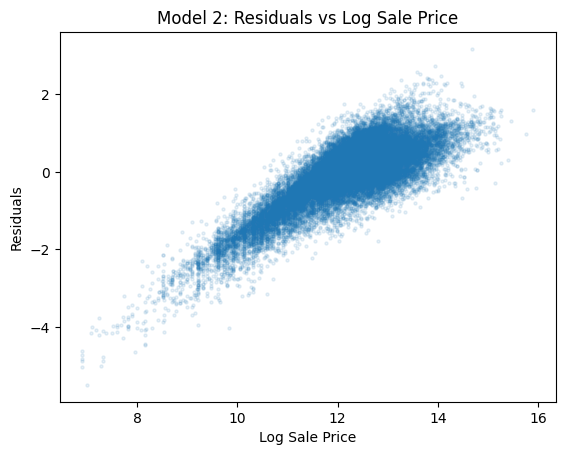

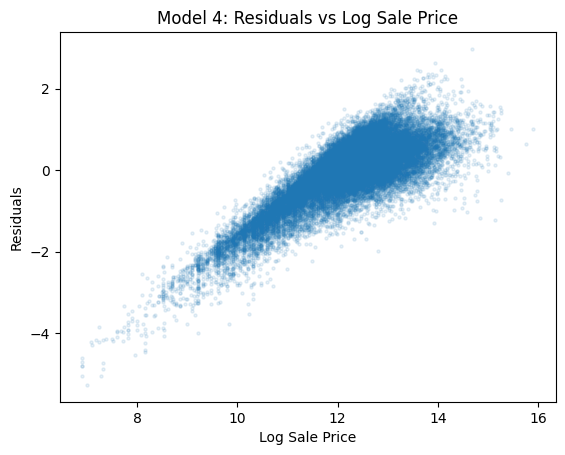

In [50]:
# Model 2
plt.scatter(y = y_validation_model_2 - y_predicted_model_2, x = y_validation_model_2, alpha = 0.1, s = 5)
plt.xlabel('Log Sale Price')
plt.ylabel('Residuals')
plt.title('Model 2: Residuals vs Log Sale Price')
plt.show()

# Model 4
plt.scatter(y = y_validation_model_4 - y_predicted_model_4, x = y_validation_model_4, alpha = 0.1, s = 5)
plt.xlabel('Log Sale Price')
plt.ylabel('Residuals')
plt.title('Model 4: Residuals vs Log Sale Price')
plt.show()

# Decision Trees

## Motivation

Linear regression fails to show the interaction between features. However, decision trees choose the optimal feature to split on based on prior information (such as what branch it is currently operating in). 

This provides a strong motivation for analyzing how decision trees would predict housing prices.


In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

dataset_decision_tree = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")

dataset_decision_tree.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


In [60]:
tree = DecisionTreeRegressor(random_state=526)
tree.fit(X_train_model_4, y_train_model_4)

y_train_pred = tree.predict(X_train_model_4)
y_validation_pred = tree.predict(X_validation_model_4)

In [63]:
train_rmse = rmse(y_train_model_4, y_train_pred)
test_rmse = rmse(y_validation_model_4, y_validation_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.743936837570163
Testing RMSE: 0.814932149744413


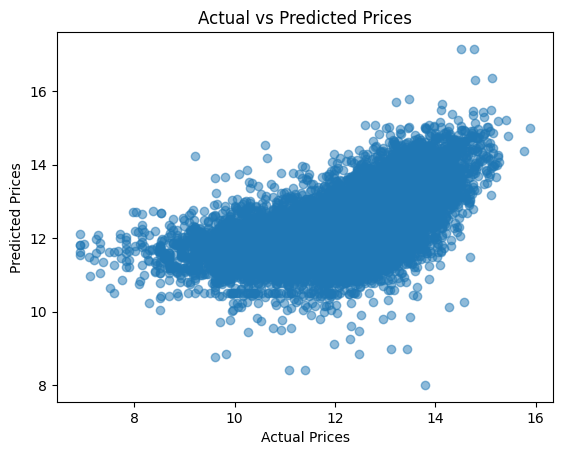

In [65]:
plt.scatter(y_validation_model_4, y_validation_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

In [70]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [10, 50, 100],
    'min_samples_leaf': [5, 10, 20],
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_model_4, y_train_model_4)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 100}


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_validation_model_4)
rmse = np.sqrt(mean_squared_error(y_validation_model_4, y_pred))

# pydot for visualize the tree, visualize splits